In [8]:
import json
import math
from typing import List, Dict, Any, Tuple
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from shapely.geometry import shape, Polygon, Point

In [9]:
def load_lga_geoms(filepath: str) -> List[Polygon]:
    """
    Load LGA polygons from a GeoJSON file.

    **arguments**:
        *filepath*: str - path to the GeoJSON file containing LGA geometries
    **returns**:
        *geoms*: List[Polygon] - list of shapely Polygon objects representing LGAs
    """
    with open(filepath) as file:
        geojsonData = json.load(file)
    geoms: List[Polygon] = []
    for feature in geojsonData['features']:
        geom = shape(feature['geometry'])
        if geom.geom_type == 'Polygon':
            geoms.append(geom)
        else:
            geoms.extend(list(geom))
    return geoms

def process_track(filepath: str, innerSquare: Polygon) -> List[Dict[str, Any]]:
    """
    Filter and process a radiacode track.

    **arguments**:
        *filepath*: str - path to the track JSON file
        *innerSquare*: Polygon - square region to include points within
    **returns**:
        *filtered*: List[Dict[str, Any]] - filtered list of marker dicts within the square and <= 5 cps
    """
    with open(filepath) as file:
        trackData = json.load(file)
    markers = sorted(trackData.get('markers', []), key=lambda m: m['date'])
    filtered: List[Dict[str, Any]] = []
    prevMarker = None
    earthRadius = 6371.0
    for marker in markers:
        if prevMarker:
            timeDelta = marker['date'] - prevMarker['date']
            phi1 = math.radians(prevMarker['lat'])
            phi2 = math.radians(marker['lat'])
            dphi = math.radians(marker['lat'] - prevMarker['lat'])
            dlmb = math.radians(marker['lon'] - prevMarker['lon'])
            a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlmb/2)**2
            distance = 2 * earthRadius * math.atan2(math.sqrt(a), math.sqrt(1-a))
            if timeDelta <= 300 and distance < 0.2:
                continue
        filtered.append(marker)
        prevMarker = marker
    result = [
        m for m in filtered
        if innerSquare.contains(Point(m['lon'], m['lat']))
        and m.get('countRate', 0) <= 5
    ]
    return result

def get_soil_data() -> Tuple[List[float], List[float], List[float], np.ndarray]:
    """
    Provide soil sample points and values.

    **arguments**:
        none
    **returns**:
        *soilLons*: List[float] - list of longitudes for soil samples
        *soilLats*: List[float] - list of latitudes for soil samples
        *soilVals*: List[float] - average count rates for soil samples
        *soilWeights*: np.ndarray - weights for soil samples
    """
    samples = [
        (-33.8995074, 151.1989871, 4.2, 4.2),
        (-33.8994501, 151.1988839, 4.1, 3.9),
        (-33.8919132, 151.2173747, 4.45, 4.45),
        (-33.8918448, 151.2173793, 4.38, 4.1),
        (-33.9134584, 151.2477973, 4.5, 4.5),
        (-33.9134584, 151.2477973, 4.3, 4.4),
        (-33.9224539, 151.2494036, 3.6, 3.6),
        (-33.9184512, 151.2047213, 4.9, 4.9),
        (-33.9184879, 151.2049409, 4.7, 4.7),
        (-33.9141395, 151.2070730, 4.4, 4.7),
    ]
    soilLats, soilLons, soilVals = [], [], []
    for lat, lon, rc1, rc2 in samples:
        soilLats.append(lat)
        soilLons.append(lon)
        soilVals.append((rc1 + rc2) / 2.0)
    soilWeights = np.full(len(soilVals), 10.0)
    return soilLons, soilLats, soilVals, soilWeights

def extrapolate_values(
    allLons: np.ndarray,
    allLats: np.ndarray,
    allVals: np.ndarray,
    allWts: np.ndarray,
    centerLon: float,
    centerLat: float,
    lonOff: float,
    latOff: float,
    nx: int = 200,
    ny: int = 200,
    sigmaKm: float = 2.0
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Extrapolate values onto a regular grid using a Gaussian kernel.

    **arguments**:
        *allLons*: np.ndarray - point longitudes
        *allLats*: np.ndarray - point latitudes
        *allVals*: np.ndarray - point values
        *allWts*: np.ndarray - point weights
        *centerLon*: float - center longitude of grid
        *centerLat*: float - center latitude of grid
        *lonOff*: float - half-width in degrees longitude
        *latOff*: float - half-height in degrees latitude
        *nx*: int - grid resolution in x
        *ny*: int - grid resolution in y
        *sigmaKm*: float - Gaussian kernel radius in kilometers
    **returns**:
        *X*: np.ndarray - meshgrid array for longitudes
        *Y*: np.ndarray - meshgrid array for latitudes
        *Z*: np.ndarray - interpolated grid values
    """
    xGrid = np.linspace(centerLon - lonOff, centerLon + lonOff, nx)
    yGrid = np.linspace(centerLat - latOff, centerLat + latOff, ny)
    X, Y = np.meshgrid(xGrid, yGrid)
    degPerKmLon = 1 / (111.32 * math.cos(math.radians(centerLat)))
    degPerKmLat = 1 / 111.32
    sigmaLon = sigmaKm * degPerKmLon
    sigmaLat = sigmaKm * degPerKmLat
    Z = np.zeros_like(X)
    W = np.zeros_like(X)
    for lonPt, latPt, val, wt in zip(allLons, allLats, allVals, allWts):
        dist2 = ((X - lonPt) / sigmaLon)**2 + ((Y - latPt) / sigmaLat)**2
        K = np.exp(-0.5 * dist2)
        Z += wt * K * val
        W += wt * K
    Z = Z / W
    return X, Y, Z

def plot_map(
    lgaGeoms: List[Polygon],
    X: np.ndarray,
    Y: np.ndarray,
    Z: np.ndarray,
    trackLons: List[float],
    trackLats: List[float],
    trackVals: List[float],
    soilLons: List[float],
    soilLats: List[float],
    soilVals: List[float],
    innerSquare: Polygon
) -> None:
    """
    Plot the final radiation map with tracks and soil samples.

    **arguments**:
        *lgaGeoms*: List[Polygon] - LGA polygons
        *X*: np.ndarray - meshgrid longitudes
        *Y*: np.ndarray - meshgrid latitudes
        *Z*: np.ndarray - interpolated values
        *trackLons*: List[float] - track longitudes
        *trackLats*: List[float] - track latitudes
        *trackVals*: List[float] - track count rates
        *soilLons*: List[float] - soil sample longitudes
        *soilLats*: List[float] - soil sample latitudes
        *soilVals*: List[float] - soil sample count rates
        *innerSquare*: Polygon - boundary polygon for plotting
    **returns**:
        *None*
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    for poly in lgaGeoms:
        xs, ys = poly.exterior.xy
        ax.plot(xs, ys, color='gray', lw=0.5)
    ax.set_xlim(X.min(), X.max())
    ax.set_ylim(Y.min(), Y.max())
    norm = Normalize(vmin=min(trackVals + soilVals), vmax=max(trackVals + soilVals))
    cmap = 'RdYlGn_r'
    ax.imshow(
        Z, origin='lower',
        extent=[X.min(), X.max(), Y.min(), Y.max()],
        cmap=cmap, norm=norm, alpha=0.6
    )
    xi, yi = innerSquare.exterior.xy
    ax.plot(xi, yi, color='black', lw=2)
    ax.scatter(trackLons, trackLats, c=trackVals, cmap=cmap, norm=norm,
               marker='o', s=20, alpha=0.7, label='Track')
    ax.scatter(soilLons, soilLats, c=soilVals, cmap=cmap, norm=norm,
               marker='x', s=200, linewidths=3, label='Soil Samples')
    fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),
                 ax=ax, label='Count Rate (counts/s)')
    ax.set_title('Radiation Tracks and Soil Samples (10×10 km)')
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='upper right')
    plt.show()

/var/folders/x5/ldszh4kd4yb5q3608lfl68zh0000gn/T/ipykernel_13001/2557367021.py:18: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  geoms.extend(list(geom))
/var/folders/x5/ldszh4kd4yb5q3608lfl68zh0000gn/T/ipykernel_13001/2557367021.py:18: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  geoms.extend(list(geom))


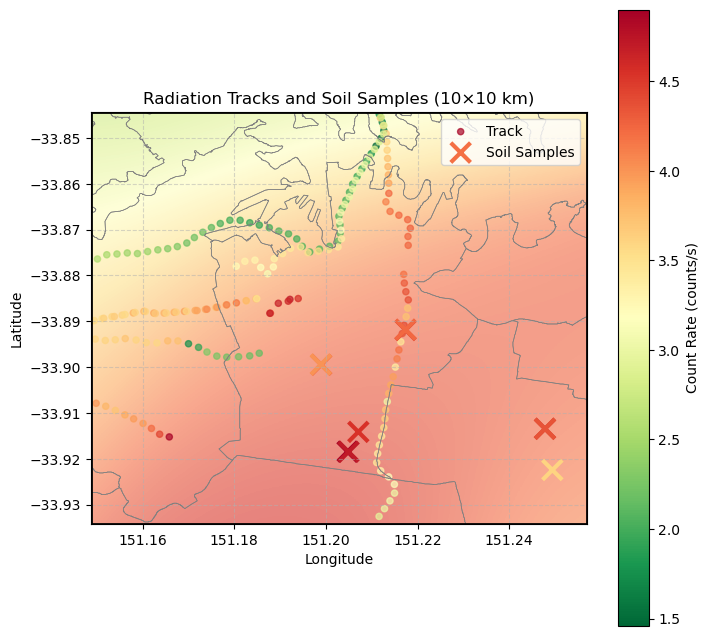

In [10]:
def main() -> None:
    """
    Main function to generate the radiation map.

    **arguments**:
        none
    **returns**:
        *None*
    """
    lgaGeoms = load_lga_geoms('data/LGAs_Sydney_and_surrounds.json')
    centerLat = -(33 + 53/60 + 21.2/3600)
    centerLon = 151 + 12/60 + 10.1/3600
    degPerKmLat = 1 / 111.32
    degPerKmLon = 1 / (111.32 * math.cos(math.radians(centerLat)))
    latOffInner = 5 * degPerKmLat
    lonOffInner = 5 * degPerKmLon
    innerSquare = Polygon([
        (centerLon - lonOffInner, centerLat - latOffInner),
        (centerLon - lonOffInner, centerLat + latOffInner),
        (centerLon + lonOffInner, centerLat + latOffInner),
        (centerLon + lonOffInner, centerLat - latOffInner),
        (centerLon - lonOffInner, centerLat - latOffInner)
    ])
    trackFiles = [
        'data/Track 06 Apr 2025 13-04-45.json',
        'data/Track 25.10.2024 12-06-48.json',
        'data/Track 25.10.2024 22-20-39.json',
        'data/Track 26.10.2024 11-11-12.json',
        'data/Track 27.10.2024 16-07-52.json'
    ]
    trackLons, trackLats, trackVals = [], [], []
    for tf in trackFiles:
        pts = process_track(tf, innerSquare)
        trackLons += [m['lon'] for m in pts]
        trackLats += [m['lat'] for m in pts]
        trackVals += [m['countRate'] for m in pts]
    trackWeights = np.full(len(trackVals), 0.1)
    soilLons, soilLats, soilVals, soilWeights = get_soil_data()
    allLons = np.array(trackLons + soilLons)
    allLats = np.array(trackLats + soilLats)
    allVals = np.array(trackVals + soilVals)
    allWts = np.concatenate([trackWeights, soilWeights])
    X, Y, Z = extrapolate_values(
        allLons, allLats, allVals, allWts,
        centerLon, centerLat, lonOffInner, latOffInner
    )
    plot_map(
        lgaGeoms, X, Y, Z,
        trackLons, trackLats, trackVals,
        soilLons, soilLats, soilVals,
        innerSquare
    )

if __name__ == '__main__':
    main()